In [45]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
import seaborn as sns
import statsmodels.api as sm
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 12, 9

## Итоговое задание

1. Зарегистрироваться на __[Kaggle](https://www.kaggle.com)__
2. Вступить в соревнование __[House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)__
3. Скачать данные
4. Обработать
5. Обучить модель
6. Сделать предсказание

Для успешного прохождения необходимо получить значение метрики меньше 0.12645

## Итоговое задание

Первым делом, необходимо обратить внимание на метрику 

$$
L = \sqrt{
    \frac{1}{N} \sum_n (\ln y_n - \ln \tilde{y}_n)^2
}
$$

In [46]:
import zipfile

z = zipfile.ZipFile("../data/house-prices-advanced-regression-techniques.zip")
df = pd.read_csv(z.open("train.csv"))
test = pd.read_csv(z.open("test.csv"))

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Трансформация признаков

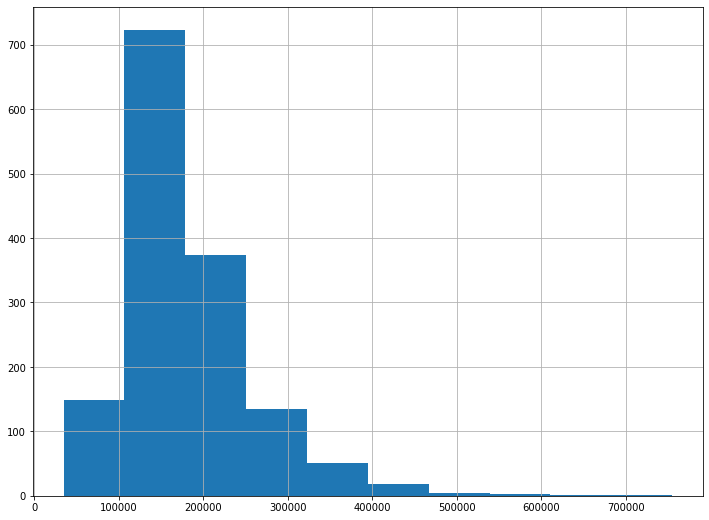

In [47]:
df['SalePrice'].hist();

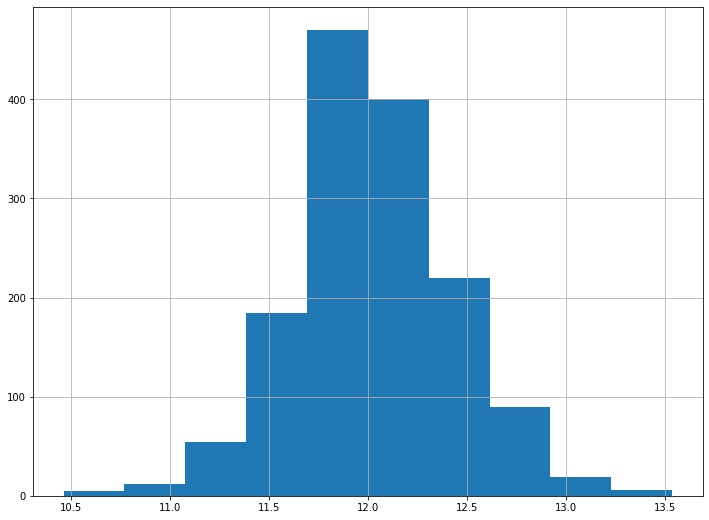

In [48]:
np.log1p(df['SalePrice']).hist();

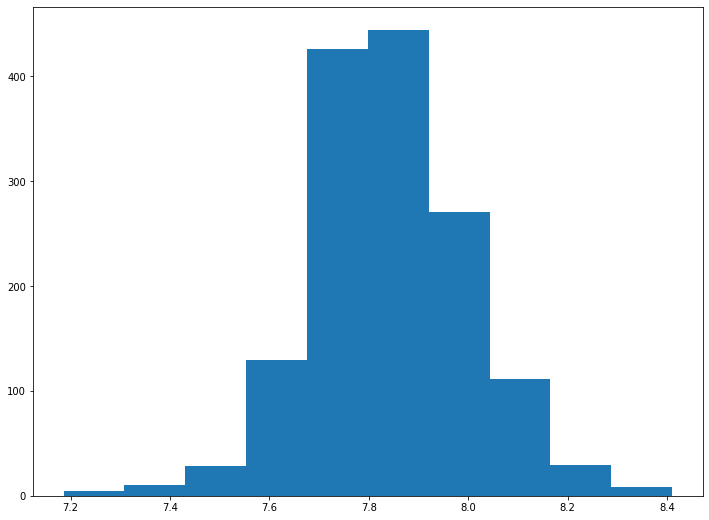

In [49]:
from sklearn.preprocessing import power_transform

tmp = power_transform(df['SalePrice'].values.reshape((-1, 1)), 
                      method='box-cox', standardize=False)
plt.hist(tmp);

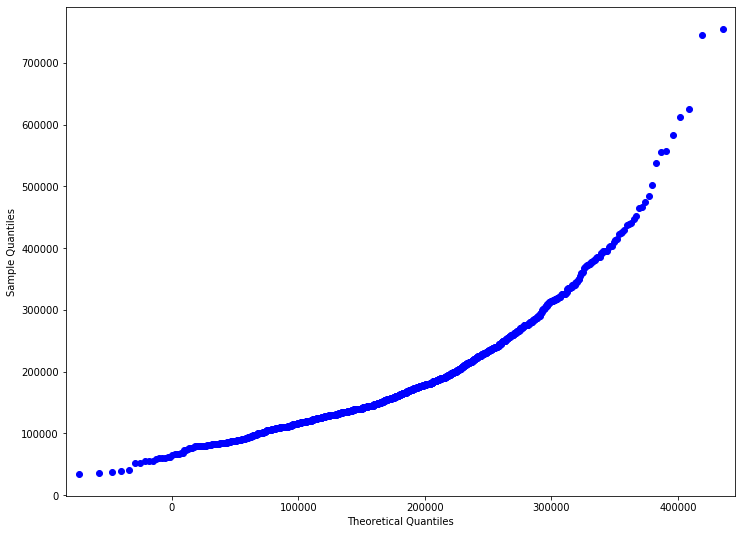

In [50]:
sm.qqplot(df['SalePrice'], 
          loc=df['SalePrice'].mean(), 
          scale=df['SalePrice'].std());

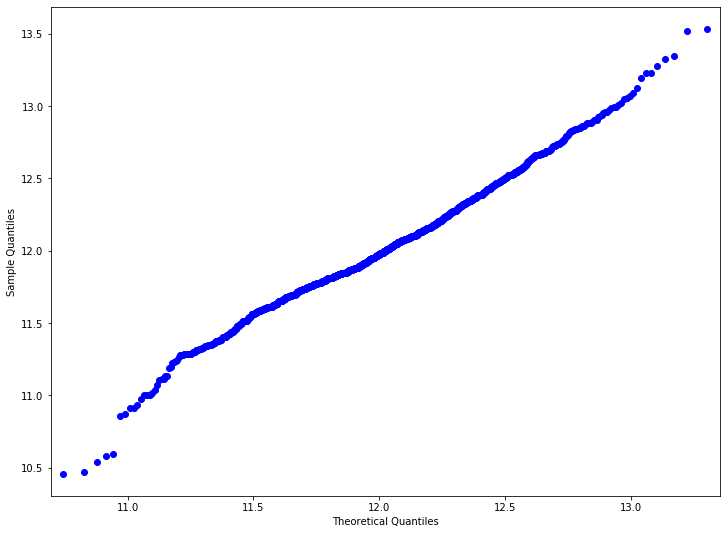

In [51]:
tmp = np.log1p(df['SalePrice'])
sm.qqplot(tmp, loc=tmp.mean(), scale=tmp.std());

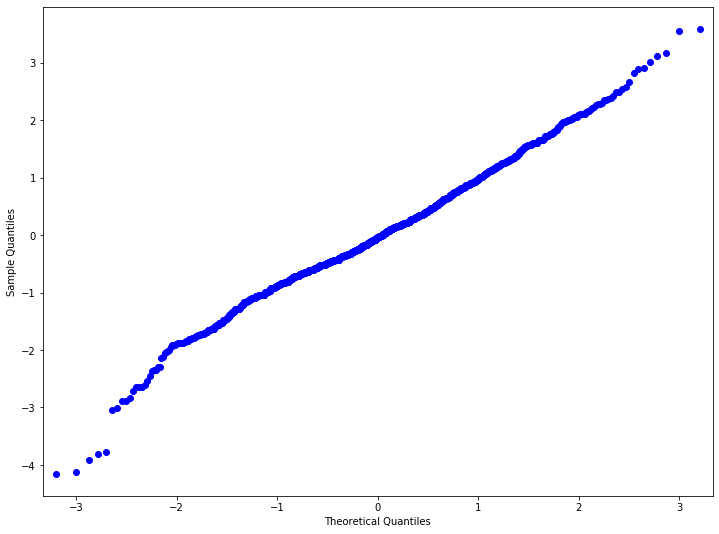

In [52]:
from sklearn.preprocessing import power_transform

tmp = power_transform(df['SalePrice'].values.reshape((-1, 1)), method='box-cox', standardize=True)
sm.qqplot(tmp.ravel(), loc=tmp.mean(), scale=tmp.std());

## Обработка категориальных данных

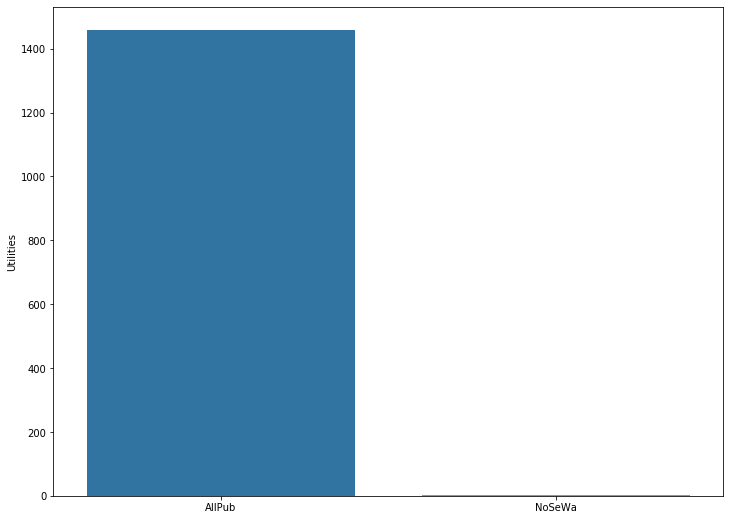

In [53]:
sns.barplot(df['Utilities'].unique(), df['Utilities'].value_counts());

In [54]:
# количество пропусков
df['Fence'].isnull().sum()

1179

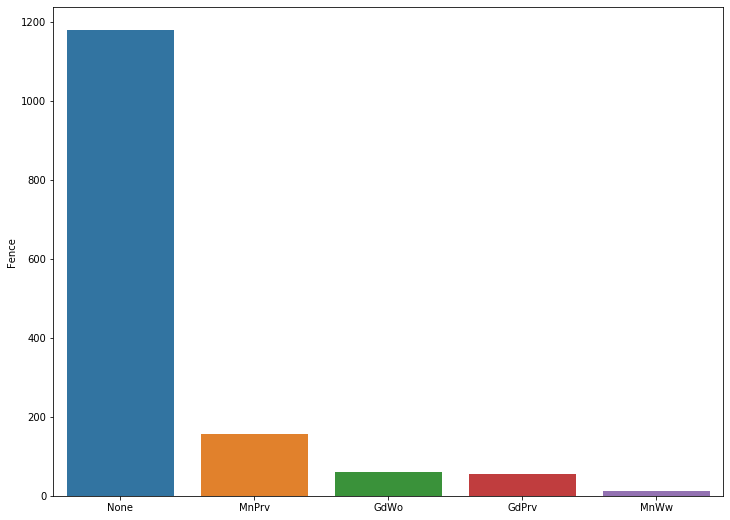

In [55]:
df['Fence'] = df['Fence'].fillna("None")
sns.barplot(df['Fence'].unique(), df['Fence'].value_counts());

## Создание новых признаков

Опыт подсказывает, что полная площадь дома должна хорошо влиять на стоимость.

In [56]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

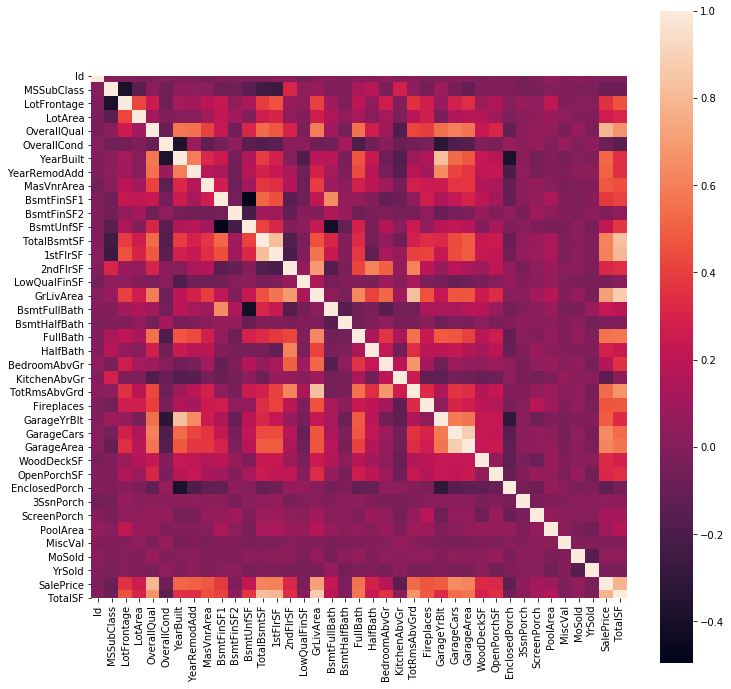

In [57]:
corrmat = df.corr()
plt.subplots(figsize=(12,12))
sns.heatmap(corrmat, square=True);

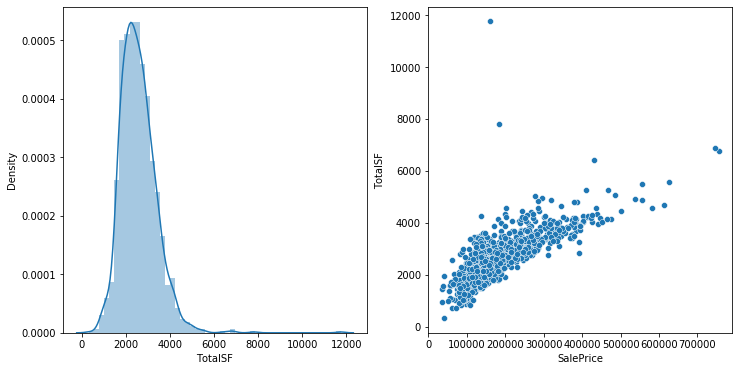

In [58]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.distplot(df['TotalSF'])
plt.subplot(122)
sns.scatterplot(df['SalePrice'], df['TotalSF'])
plt.show()

In [59]:
from sklearn.linear_model import LinearRegression

In [60]:
train_data = df.drop(['SalePrice', 'Id'], axis=1)
train_output = df['SalePrice']
test_data = test.drop('Id', axis=1)

In [61]:
identifier = lambda x: x

scores = {}

def train_dev_split(data, frac = 0.8):
    train = data.sample(frac=frac, random_state=3)
    train_indexes = data.index.isin(train.index.values)
    dev = data.drop(train.index.values, axis=0)
    dev_indexes = data.index.isin(dev.index.values)
    return (train_indexes, dev_indexes)

def rmsle(real, predicted):
    s=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        s = s + (p - r)**2
    return (s/len(predicted))**0.5

def score(model, data, data_selector, is_rmsle=False):
    y, X, _, train_ids, dev_ids = data
    dev_s = .0
    train_s = .0
    if X is not None:
        d = data_selector(y, X)
        if d.shape[1] > 0:
            X_train, X_dev, y_train, y_dev = d[train_ids], d[dev_ids], y[train_ids], y[dev_ids]
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_train, y_train)
                if is_rmsle:
                    pred = model.predict(X_dev)
                    dev_s = rmsle(y_dev.values, pred)
                    pred = model.predict(X_train)
                    train_s = rmsle(y_train.values, pred)
                else:
                    dev_s = model.score(X_dev, y_dev)
                    train_s = model.score(X_train, y_train)
    return dev_s, train_s

def validateModels(data, models, new_selector, data_transformer=identifier, is_rmsle=False):
    new_data = data_transformer(data)
    new_models = {}
    for key, (model, selector) in models.items():
        s1, t1 = (0, 0)
        s2, t2 = (0, 0)
        if selector is not None:
            s1, t1 = score(model, data, selector, is_rmsle)
            s2, t2 = score(model, new_data, selector, is_rmsle)
        s3, t3 = score(model, new_data, new_selector, is_rmsle)
        if s2 >= s3:
            new_models[key] = (model, selector)
            scores[key] = s2
            print(f'{key} = dev accuracy {s2} - change by {s2 - s1}, train accuracy {t2}')
        else:
            new_models[key] = (model, new_selector)
            scores[key] = s3
            print(f'{key} = dev accuracy {s3} - change by {s3 - s1}, train accuracy {t3}')
    return (new_data, new_models)

def submit_model(data, model, name=''):
    alg, selector = model
    train_output, train_data, test_data, _, _ = data
    train_data = selector(train_output, train_data)
    alg.fit(train_data, train_output)
    pred = alg.predict(test_data)
    my_submission = pd.DataFrame({'Id': test.Id.values, 'SalePrice': np.expm1(pred).reshape(-1)})
    my_submission.to_csv(name + 'submission.csv', index=False)

In [62]:
models = {
    'linear_regression' : (LinearRegression(n_jobs=-1), None)
}

def chooser(y, X):
    d = X.dropna(axis=1)
    series = d.corrwith(y)
    high_corr_columns = set(series[series > 0.5].index.values)
    number_columns = set(d.select_dtypes(include=['number']).columns.values)
    cols = list(high_corr_columns.intersection(number_columns))
    return d[cols]

def setter(dataset):
    train_rows, dev_rows = train_dev_split(train_data)
    return (train_output.copy(), train_data.copy(), test_data.copy(), train_rows, dev_rows)
train_ds, dev_ids = train_dev_split(train_data)
data = (None, None, None, None)
data, models = validateModels(data, models, chooser, setter)

linear_regression = dev accuracy 0.796887514658089 - change by 0.796887514658089, train accuracy 0.7671808902226622
